In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline
import import_ipynb
import random
from matplotlib.gridspec import GridSpec
import pandas as pd
import glob

In [2]:
import os
os.chdir('F:/我的雲端硬碟/Retina exp/python code/functions')
import import_ipynb
import NGDfunc
from NGDfunc import MI,xcorr_quick,NGD,poisson,EqualState,OU,FFT_quick

importing Jupyter notebook from NGDfunc.ipynb


## Load data / find cross-correlation of ganglion cell output

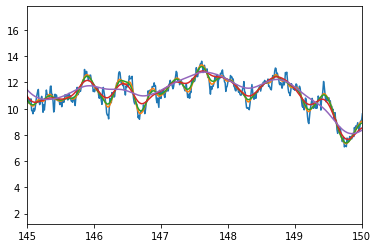

In [3]:


dt_ou=0.01 # the sampling rate of OU; same to experiment
dt=0.01 # iteration step for euler method
tau_ou=0.5
fc=[5,3.5,2,1]
T_ou=300
nsteps_ou=int(T_ou/dt_ou)
amp=2
mean=10
x_lpou=[0 for i in range(len(fc))]
randseed = np.random.normal(0, 50, nsteps_ou)
time_ou,x_ou=OU(T_ou,tau_ou,'no',dt_ou,randseed)
x_set=[x_ou/np.std(x_ou)*amp+mean]
for i in range(len(fc)):
    time_ou,x_lpou=OU(T_ou,tau_ou,fc[i],dt_ou,randseed)
    x_set.append(x_lpou/np.std(x_lpou)*amp+mean)

for i in range(len(x_set)):
#     x_set[i]=np.repeat(x_set[i],10)
    time=np.arange(1,len(x_set[0])+1e-5)*dt
    plt.plot(time,x_set[i])
    plt.xlim(145,150)


## NGD output

In [4]:
alpha,beta,K,g=6,1.6,22,10 # channel 39
# alpha,beta,K,g=8,1.4,37,10 # channel 47
y_set=[NGD(x_set[j],dt,alpha,beta,K,g,1)[0] for j in range(np.size(x_set,0))] 
z_set=[NGD(x_set[j],dt,alpha,beta,K,g,1)[1] for j in range(np.size(x_set,0))] 

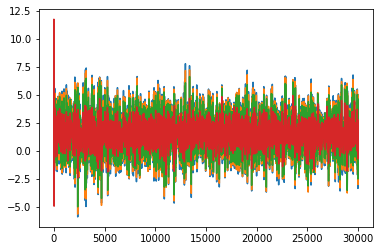

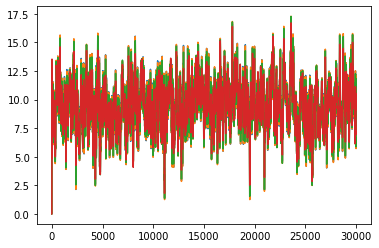

In [5]:
for i in range(4):
    plt.plot(y_set[i])
plt.ylim()
plt.xlim()
plt.show()
for i in range(4):
    plt.plot(z_set[i])
# plt.ylim(-1,4)
# plt.xlim(2000,4000)

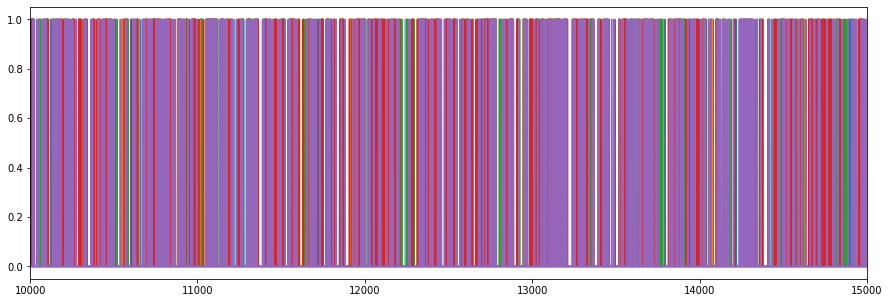

In [6]:
f0,ax0=plt.subplots(figsize=(15,5))
spikeon_fc=[0 for i in range(len(x_set))]
MI_fc=[0 for i in range(len(x_set))]
MI_fc=[0 for i in range(len(x_set))]
for j in range(len(x_set)):
    spikeon_fc[j]=poisson(y_set[j],3,1,dt)
    tl_fc,MI_fc[j]=MI(EqualState(x_set[j],8),spikeon_fc[j],dt,[-1,1])
    
    ax0.plot(spikeon_fc[j])
    ax0.set_xlim(10000,15000)

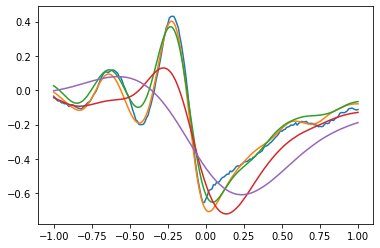

In [7]:
corr_ou=[0 for i in range(len(x_set))]
for numset in range(len(x_set)):
    ts,corr_ou[numset]=xcorr_quick(x_set[numset]-np.mean(x_set[numset]),spikeon_fc[numset],[-1,1],dt)
    plt.plot(ts,corr_ou[numset]/np.sum(spikeon_fc[numset]))


Text(0.5, 0, 'time to spike (s)')

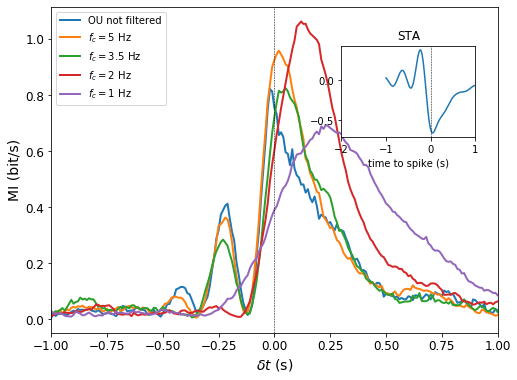

In [8]:
f0mi,ax0mi=plt.subplots(figsize=(8,6))
ax_inset=ax0mi.inset_axes([0.65, 0.6, 0.3, 0.28])
for j in range(len(x_set)):    
    ax0mi.plot(tl_fc,MI_fc[j],lw=2)
ax0mi.set_xlim(-1,1)
ax0mi.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# ax0mi.set_ylim(0,1.1)
ax0mi.tick_params(axis='x',labelsize='12')
ax0mi.tick_params(axis='y',labelsize='12')
ax0mi.set_xlabel(r'$\delta t$ (s)',fontsize='14')
ax0mi.set_ylabel('MI (bit/s)',fontsize='14')
ax0mi.legend(('OU not filtered',r'$f_c=5$ Hz',r'$f_c=3.5$ Hz',r'$f_c=2$ Hz',r'$f_c=1$ Hz'),bbox_to_anchor=(0,0.5,0.5,0.5))
ax_inset.plot(ts,corr_ou[2]/np.sum(spikeon_fc[numset]))
ax_inset.set_title('STA')
ax_inset.xaxis.set_ticks([-2,-1,0,1])
ax_inset.set_xlim(-2,1)
ax_inset.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# ax_inset.set_ylim(-0.6,0.8)
ax_inset.tick_params()
ax_inset.set_xlabel('time to spike (s)')



### u(t)

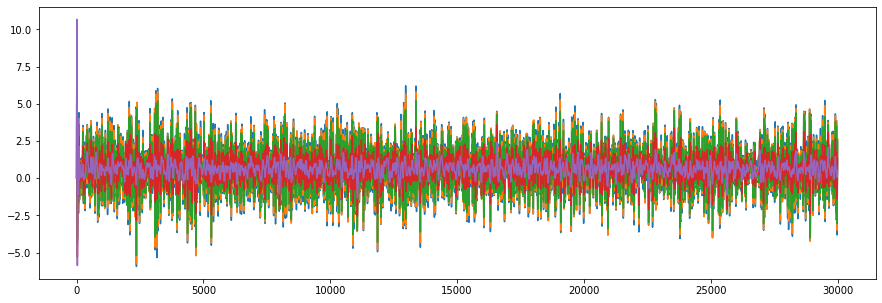

In [9]:
psi=0.08
B_set=[(1-psi)*y_set[k]-psi*z_set[k] for k in range(len(x_set))]
fb,axb=plt.subplots(figsize=(15,5))
for i in range(len(B_set)):
    axb.plot(B_set[i])

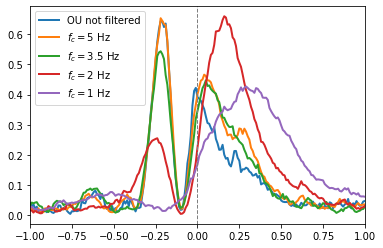

In [10]:
MI_B=[0 for i in range(len(x_set))]
spikes_B_on=[0 for i in range(len(x_set))]
fu1,axu1=plt.subplots(figsize=(6,4))
for i in range(len(x_set)):
    spikes_B_on[i]=poisson(B_set[i],1.9,1,dt)
    tl,MI_B[i]=MI(EqualState(x_set[i],8),spikes_B_on[i],dt,[-1,1])
    plt.plot(tl,MI_B[i],lw=2)
    plt.xlim(-1,1)
plt.legend(('OU not filtered',r'$f_c=5$ Hz',r'$f_c=3.5$ Hz',r'$f_c=2$ Hz',r'$f_c=1$ Hz'))
plt.axvline(x=0,linewidth=1,linestyle='--',color=[0.5,0.5,0.5])

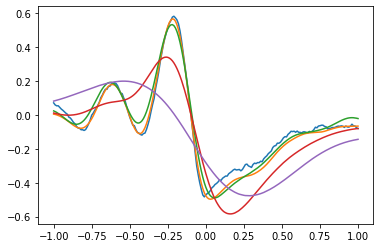

In [11]:
# xcorr
corr_B=[0 for i in range(len(x_set))]
for numset in range(len(x_set)):
    ts,corr_B[numset]=xcorr_quick(x_set[numset]-np.mean(x_set[numset]),spikes_B_on[numset],[-1,1],dt)
    plt.plot(ts,corr_B[numset]/np.sum(spikes_B_on[numset]))


In [12]:
imin=np.argmax(corr_B[3])
print(ts[imin])

-0.26


### experiment data

In [13]:
selected_channel=31

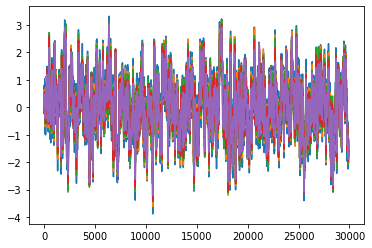

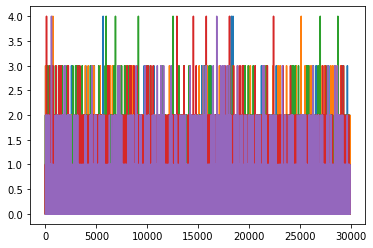

In [14]:
os.chdir('F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200408/')
mat_files=[i for i in glob.glob('*.mat')] # get file name in a directory
mat_files=sorted(mat_files) # sort file sequence by name
# for i in range(len(mat_files)):
#     print(i,mat_files[i])
selected_files=[34,22,31,28,25]

BinSpikes_set=[[] for k in range(np.size(selected_files,0))]
sti_set=[[] for k in range(np.size(selected_files,0))] 
dt=0.01
for i in range(np.size(selected_files,0)):
    data1=loadmat(mat_files[selected_files[i]])
    spikes=data1['Spikes'][0][selected_channel][0]
    timestamp=data1['TimeStamps'][0]

    adata1=data1['a_data'][0]
    t=np.arange(1,len(adata1)+1e-5)/20000
    sti=adata1[(t>timestamp[0]) & (t<timestamp[1])][0:-1:200]
    sti=sti-np.mean(sti)
    sti_set[i]=sti/np.std(sti)

    spikes1=spikes[(spikes>timestamp[0]) & (spikes<timestamp[1])]-timestamp[0]
    BinningTime=np.arange(0,timestamp[1]-timestamp[0],0.01)
    BinSpikes_set[i], bin_edges=np.histogram(spikes1,bins=BinningTime)
    
x_exp=[sti_set[k][:-1] for k in range(len(sti_set))]
time=np.linspace(dt,300,np.size(x_set[1]))
for i in range(len(x_exp)):
    plt.plot(x_exp[i])
# plt.xlim(15000,17000)
plt.show()
for i in range(len(BinSpikes_set)):
    plt.plot(BinSpikes_set[i])
# plt.xlim(10000,11000)

(5000, 10000)

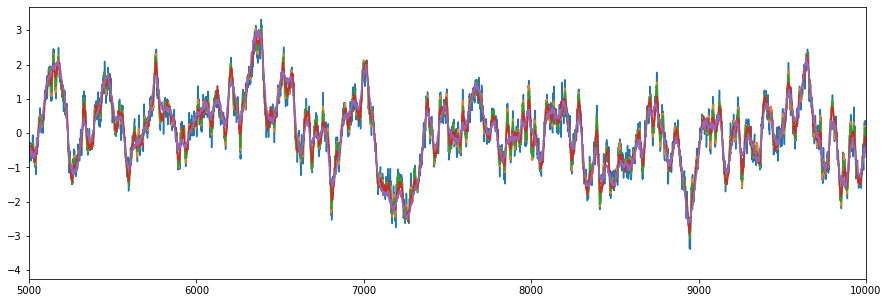

In [15]:
f1,ax1=plt.subplots(figsize=(15,5))
for i in range(len(x_exp)):
    plt.plot(x_exp[i])
plt.xlim(5000,10000)

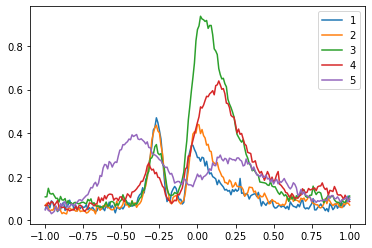

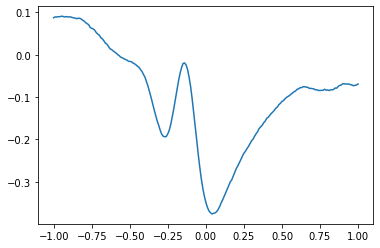

In [16]:
f2,ax2=plt.subplots()
f3,ax3=plt.subplots()
MI_exp=[0 for i in range(len(x_exp))]
corr_exp=[0 for i in range(len(x_exp))]
for i in range(len(x_exp)):
    tl_exp,MI_exp[i]=MI(EqualState(x_exp[i],8),BinSpikes_set[i],dt,[-1,1])
    ax2.plot(tl_exp,MI_exp[i])
    tc_exp,corr_exp[i]=xcorr_quick(x_exp[i],BinSpikes_set[i],[-1,1],dt)
ax3.plot(tc_exp,corr_exp[2]/np.sum(BinSpikes_set[2]))
ax2.legend(('1','2','3','4','5'))

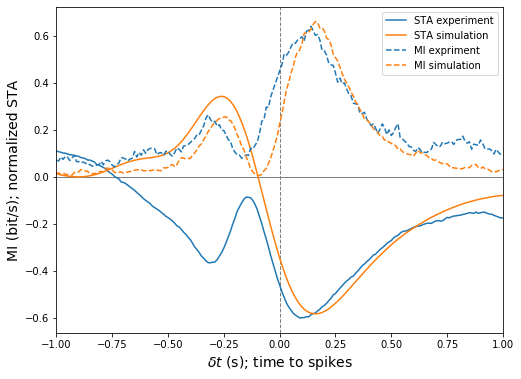

In [17]:
nset=3
c_set=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
fs,axs=plt.subplots(figsize=(8,6))
axs.axhline(y=0,linewidth=1,linestyle='-',color=[0.5,0.5,0.5])
axs.axvline(x=0,linewidth=1,linestyle='--',color=[0.5,0.5,0.5])
axs.plot(tc_exp,corr_exp[nset]/np.sum(BinSpikes_set[nset])*2,c='tab:blue',label='STA experiment')
axs.plot(ts,corr_B[nset]/np.sum(spikes_B_on[nset]),c='tab:orange',label='STA simulation')
axs.plot(tl_exp,MI_exp[nset],c='tab:blue',ls='--',label='MI expriment')
axs.plot(tl,MI_B[nset],c='tab:orange',ls='--',label='MI simulation')
axs.set_xlim(-1,1)
axs.set_ylabel('MI (bit/s); normalized STA',fontsize=14)
axs.set_xlabel(r'$\delta t$ (s); time to spikes',fontsize=14)
axs.legend()

In [18]:
# fs.savefig('F:/我的雲端硬碟/Master Thesis/Figures/Discussion/STA exp sim comparison.pdf')

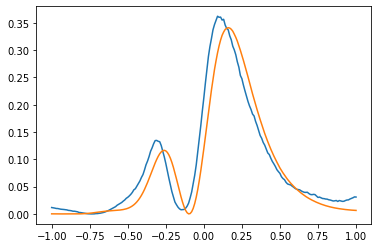

In [19]:
fsta2,axsta2=plt.subplots()
plt.plot(tc_exp,(corr_exp[nset]/np.sum(BinSpikes_set[nset])*2)**2,c='tab:blue',label='STA experiment')
plt.plot(ts,(corr_B[nset]/np.sum(spikes_B_on[nset]))**2,c='tab:orange',label='STA simulation')


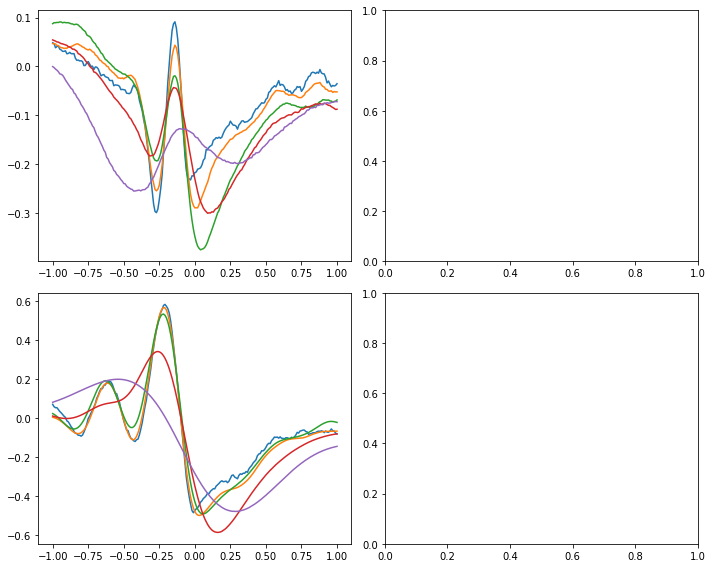

In [20]:
c_set=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
fSTA=plt.figure(figsize=(10,8))
gs = GridSpec(2, 2, figure=fSTA)
ax1=fSTA.add_subplot(gs[0,0])
ax2=fSTA.add_subplot(gs[1,0])
ax3=fSTA.add_subplot(gs[0,1])
ax4=fSTA.add_subplot(gs[1,1])
for i in range(len(spikeon_fc)):
#     plt.plot(ts,corr_ou[i]/np.sum(spikeon_fc[numset]),ls='-',c=c_set[i])
    ax1.plot(tc_exp,corr_exp[i]/np.sum(BinSpikes_set[i]),ls='-',c=c_set[i])
    ax2.plot(ts,corr_B[i]/np.sum(spikes_B_on[i]),ls='-',c=c_set[i])
    
    
fSTA.tight_layout()

### spike artocorrelation

(0, 4)

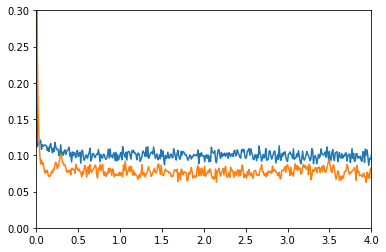

In [21]:
tl_spikes_sim,corr_spikes_sim=xcorr_quick(spikeon_fc[numset],spikeon_fc[numset],[-5,5],dt)
tl_spikes_exp,corr_spikes_exp=xcorr_quick(BinSpikes_set[2],BinSpikes_set[2],[-5,5],dt)
plt.plot(tl_spikes_sim,corr_spikes_sim/max(corr_spikes_sim))#/np.sum(spikeon_fc[numset])/np.sum(spikeon_fc[numset]))
plt.plot(tl_spikes_exp,corr_spikes_exp/max(corr_spikes_exp))#/np.sum(BinSpikes_set[2])/np.sum(BinSpikes_set[2]))
plt.ylim(0,0.3)
plt.xlim(0,4)

In [22]:
print(max(corr_spikes_sim),max(corr_spikes_exp))
print(np.sum(spikeon_fc[numset]),np.sum(BinSpikes_set[2]))

3039.0 4324.0
3039.0 3156


### spetrum

In [23]:
f_x,a_x,p_x=FFT_quick(x_set[2],dt)
f_y,a_y,p_y=FFT_quick(y_set[2],dt)

### analytical result

In [24]:
# analytic result 
omega=np.arange(0,50,0.001)
A=np.zeros(len(omega))
B=np.zeros(len(omega))
for i in range(len(omega)):
    A[i]=alpha*beta**2+g*beta*K+omega[i]**2*alpha
    B[i]=-omega[i]**3+omega[i]*g*K-beta**2*omega[i]
# phase
phi_ana=np.zeros(len(omega))
for i in range(len(omega)):
    phi_ana[i]=math.atan(B[i]/A[i])
# group
delta_ana=-np.diff(phi_ana)/(omega[1]-omega[0])
# gain
C=np.zeros(len(omega))
for i in range(len(omega)):
    C[i]=(-omega[i]**2+alpha*beta+g*K)**2+(omega[i]*(alpha+beta))**2
gain_ana=K/C*(A**2+B**2)**(1/2)

### plot thesis figure

ValueError: x and y must have same first dimension, but have shapes (201,) and (5, 201)

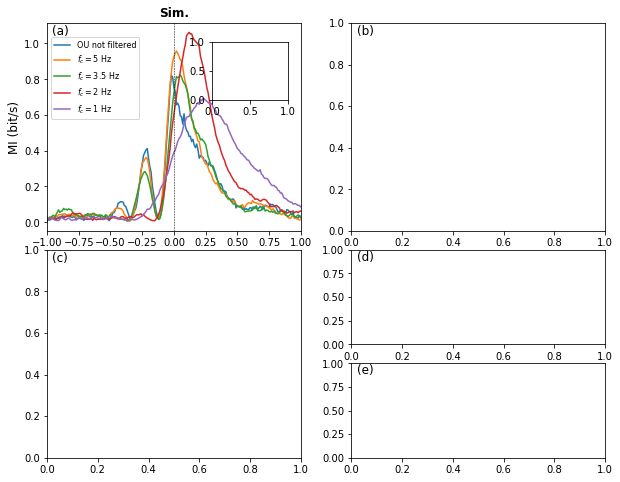

In [25]:
ff=plt.figure(figsize=(10,8))
gs = GridSpec(4, 2, figure=ff)
ax1=ff.add_subplot(gs[0:2,0])
ax2=ff.add_subplot(gs[0:2,1])
ax3=ff.add_subplot(gs[2:,0])
ax4=ff.add_subplot(gs[2,1])
ax5=ff.add_subplot(gs[3,1])

# from matplotlib.offsetbox import AnchoredText
# ax1.add_artist(AnchoredText('(a)', loc=2))
ax1.text(0.02, 0.99, '(a)', transform=ax1.transAxes, fontsize=12,\
        verticalalignment='top')
ax2.text(0.02, 0.99, '(b)', transform=ax2.transAxes, fontsize=12,\
        verticalalignment='top')
ax3.text(0.02, 0.99, '(c)', transform=ax3.transAxes, fontsize=12,\
        verticalalignment='top')
ax4.text(0.02, 0.99, '(d)', transform=ax4.transAxes, fontsize=12,\
        verticalalignment='top')
ax5.text(0.02, 0.99, '(e)', transform=ax5.transAxes, fontsize=12,\
        verticalalignment='top')


# ================ 1 ==============
ax1_inset=ax1.inset_axes([0.65, 0.63, 0.3, 0.28])
for j in range(len(x_set)):    
    ax1.plot(tl_fc,MI_fc[j],lw=1.5)
ax1.set_xlim(-1,1)
ax1.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# ax0mi.set_ylim(0,1.1)
# ax1.tick_params(axis='x',labelsize='12')
# ax1.tick_params(axis='y',labelsize='12')
ax1.set_xlabel(r'$\delta t$ (s)',fontsize='12')
ax1.set_ylabel('MI (bit/s)',fontsize='12')
ax1.legend(('OU not filtered',r'$f_c=5$ Hz',r'$f_c=3.5$ Hz',r'$f_c=2$ Hz',r'$f_c=1$ Hz'),\
           bbox_to_anchor=(0,0.45,0.5,0.5),fontsize=8)
ax1.set_title('Sim.',fontweight='bold')
ax1_inset.plot(ts,corr_ou/np.sum(spikeon_fc[numset]),c='tab:green')
ax1_inset.set_title('STA')
ax1_inset.xaxis.set_ticks([-2,-1,0,1])
ax1_inset.set_xlim(-2,1)
ax1_inset.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# ax_inset.set_ylim(-0.6,0.8)
ax1_inset.tick_params()
ax1_inset.set_xlabel('time to spike (s)')

# ================ 2 =================
ax2_inset=ax2.inset_axes([0.65, 0.63, 0.3, 0.28])
for j in range(len(x_set)):    
    ax2.plot(tl_exp,MI_exp[j],lw=1.5)
ax2.set_xlim(-1,1)
ax2.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# ax2.tick_params(axis='x',labelsize='12')
# ax2.tick_params(axis='y',labelsize='12')
ax2.set_xlabel(r'$\delta t$ (s)',fontsize='12')
ax2.set_ylabel('MI (bit/s)',fontsize='12')
ax2.legend(('OU not filtered',r'$f_c=5$ Hz',r'$f_c=3.5$ Hz',r'$f_c=2$ Hz',r'$f_c=1$ Hz'),\
           bbox_to_anchor=(0,0.45,0.5,0.5),fontsize=8)
ax2.set_title('Exp.',fontweight='bold')
ax2_inset.plot(tc_exp,corr_exp[2]/np.sum(BinSpikes_set[2]),c='tab:green')
ax2_inset.set_title('STA')
ax2_inset.xaxis.set_ticks([-2,-1,0,1])
ax2_inset.set_xlim(-2,1)
ax2_inset.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
ax2_inset.tick_params()
ax2_inset.set_xlabel('time to spike (s)')

# ================ 3 ====================
ax3.plot(tl_spikes_sim,corr_spikes_sim/np.sum(spikeon_fc[numset]),c='b')
ax3.plot(tl_spikes_exp,corr_spikes_exp/np.sum(BinSpikes_set[2]),c='g')
ax3.set_ylim(0,0.3)
ax3.set_xlim(0,4)
ax3.set_xlabel('lagging time (s)',fontsize='12')
ax3.set_ylabel('Autocorrelation',fontsize='12')
ax3.legend(('Simulation','Experiment'))


# ================ 4 =====================
ax4.plot(f_x,a_x)
ax4.plot(f_y,a_y,alpha=0.8)
ax4.set_xlim(0,5)
ax4.set_ylim(0,0.3)
ax4.set_xlabel('frequency (Hz)',fontsize='12')
ax4.set_ylabel('amplitude',fontsize='12')
ax4.legend(('x(t)','y(t)'))

# ================ 5 ========================
ax5_2=ax5.twinx()
l1=ax5.plot(omega[0:-1]/2/math.pi,delta_ana,c='b',label='group delay')
l2=ax5_2.plot(omega/2/math.pi,gain_ana,c='r',label='gain')
ax5.set_xlim(0,5)
ax5.set_ylim(-0.7,1)
ax5.set_xlabel('frequency (Hz)',fontsize='12')
ax5.set_ylabel('group delay (s)',fontsize='12')
ax5_2.set_ylabel('gain',fontsize='12')
l12=l1+l2
labs=[l.get_label() for l in l12]
ax5.legend(l12, labs, loc=0, facecolor='white',framealpha=0.5)
ax5.axhline(y=0,c='k',linewidth=0.5,linestyle='dashed')



ff.tight_layout() 

In [ ]:
ff.savefig('F:/我的雲端硬碟/Master Thesis/Figures/Simulation result/intrinsic frequency.pdf')